In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random

In [125]:
CHECKERBOARD = (10,7)
square_size = 35#mm
images_glob = '/catkin_ws/src/dataset/calib/fish1280x960A3/02/*.png'
img_size = (1280, 960)

# CHECKERBOARD = (9,7)
# square_size = 20#mm
# images_glob = '/catkin_ws/src/dataset/calib/fish1280x960/**/*.jpeg'
# img_size = (1280, 960)

objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= square_size

subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)

calibration_flags = 0
# calibration_flags |= cv2.fisheye.CALIB_USE_INTRINSIC_GUESS
calibration_flags |= cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
# calibration_flags |= cv2.fisheye.CALIB_CHECK_COND
calibration_flags |= cv2.fisheye.CALIB_FIX_SKEW
# calibration_flags |= cv2.fisheye.CALIB_FIX_K1
# calibration_flags |= cv2.fisheye.CALIB_FIX_K2
# calibration_flags |= cv2.fisheye.CALIB_FIX_K3
# calibration_flags |= cv2.fisheye.CALIB_FIX_K4
# calibration_flags |= cv2.fisheye.CALIB_FIX_INTRINSIC
calibration_flags |= cv2.fisheye.CALIB_FIX_PRINCIPAL_POINT
# calibration_flags |= cv2.fisheye.CALIB_ZERO_DISPARITY

find_corners_flags = 0
find_corners_flags |= cv2.CALIB_CB_ADAPTIVE_THRESH
find_corners_flags |= cv2.CALIB_CB_FAST_CHECK
find_corners_flags |= cv2.CALIB_CB_NORMALIZE_IMAGE



image_paths = glob.glob(images_glob)
print('found {} images'.format(len(image_paths)))

objpoints = [] # 3d point in real world spacec
imgpoints = [] # 2d points in image plane.
_img_shape = None
idx2image_path = {}

for img_path in image_paths:
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CHECKERBOARD[0],CHECKERBOARD[1]), find_corners_flags)

    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
        idx2image_path[len(objpoints)] = img_path


N_OK = len(objpoints)
print("Found " + str(N_OK) + " valid images for calibration")
mtx = np.zeros((3, 3))
dist = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
ret, mtx, dist, rvecs, tvecs = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        img_size,
        mtx,
        dist,
        rvecs,
        tvecs,
        flags = calibration_flags,
        criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )


print("RET", ret)

mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )



print("DIM=" + str(_img_shape[::-1]))
print(mtx, '\n', dist)
print("Camera.fx:", mtx[0][0])
print("Camera.fy:", mtx[1][1])
print("Camera.cx:", mtx[0][2])
print("Camera.cy:", mtx[1][2])
print('Camera.k1:', dist[0][0])
print('Camera.k2:', dist[1][0])
print('Camera.k3:', dist[2][0])
print('Camera.k4:', dist[3][0])



found 65 images
Found 60 valid images for calibration
RET 0.3918415013918627
total error: 6.662407252580735
DIM=(1280, 960)
[[7.34640325e+02 3.28917367e-02 6.24229949e+02]
 [0.00000000e+00 7.37599293e+02 4.78283983e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 [[-0.01304409]
 [-0.03868581]
 [ 0.04244893]
 [-0.02172629]]
Camera.fx: 734.640324503592
Camera.fy: 737.5992929694211
Camera.cx: 624.2299489958693
Camera.cy: 478.28398272243544
Camera.k1: -0.013044091363852487
Camera.k2: -0.03868581396280938
Camera.k3: 0.04244893310740453
Camera.k4: -0.02172629475076661


32


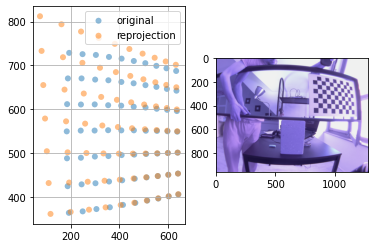

In [137]:
import matplotlib.pyplot as plt

i=np.random.randint(len(imgpoints))
print(i)
fig, ((ax, ax_im)) = plt.subplots(1,2)
color = 'tab:blue'
x = imgpoints[i][:,0,0]
y = imgpoints[i][:,0,1]
# scale = 200.0 * np.random.rand(n)
ax.scatter(x, y, c=color, alpha=0.5, label="original", edgecolors='none')

color = 'tab:orange',
imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
x = imgpoints2[:,0,0]
y = imgpoints2[:,0,1]
ax.scatter(x, y, c=color, alpha=0.5, label="reprojection", edgecolors='none')

ax.legend()
ax.grid(True)

im = cv2.imread(idx2image_path[i])
ax_im.imshow(im)

plt.show()


In [39]:
imgpoints2[:,0,1]

array([905.3801 , 909.29083, 913.1406 , 916.9546 , 920.75555, 924.5632 ,
       928.393  , 932.2555 , 936.1546 , 940.08636, 848.78766, 851.9098 ,
       855.00165, 858.0864 , 861.1851 , 864.3165 , 867.4959 , 870.7345 ,
       874.03827, 877.40686, 792.80316, 795.1964 , 797.58514, 799.9898 ,
       802.4295 , 804.92126, 807.47974, 810.1161 , 812.83746, 815.64594,
       737.5702 , 739.2889 , 741.02435, 742.79443, 744.61584, 746.5037 ,
       748.4713 , 750.5295 , 752.6856 , 754.9434 , 683.1923 , 684.2846 ,
       685.4117 , 686.5885 , 687.82916, 689.1468 , 690.553  , 692.0577 ,
       693.6682 , 695.3893 , 629.7421 , 630.2503 , 630.8085 , 631.4287 ,
       632.1226 , 632.901  , 633.77374, 634.7495 , 635.8353 , 637.0364 ,
       577.26886, 577.22925, 577.2528 , 577.34875, 577.5261 , 577.79333,
       578.15857, 578.6291 , 579.2114 , 579.9109 ], dtype=float32)

In [63]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)
    total_error += error*error
print( "rms error: {}".format(np.sqrt(total_error/(len(objpoints)*len(imgpoints2)))))

tot_error=0
total_points=0
for i in range(len(objpoints)):
    reprojected_points, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    reprojected_points=reprojected_points.reshape(-1,2)
    tot_error+=np.sum(np.abs(imgpoints[i]-reprojected_points)**2)
    total_points+=len(objpoints[i])

mean_error=np.sqrt(tot_error/total_points)
print ("Mean reprojection error: ", mean_error)




total error: 6.661255248695649
rms error: 69.32999120197839
Mean reprojection error:  17308.217739944612


TypeError: axis() got an unexpected keyword argument 'cmap'

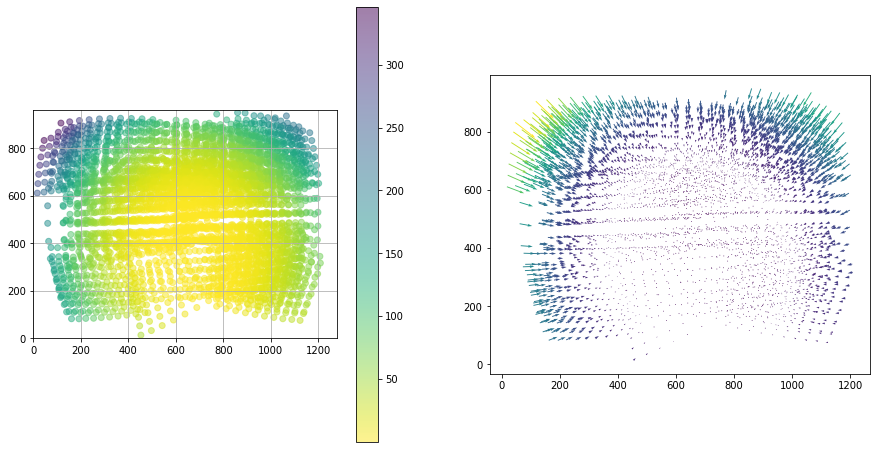

In [175]:
x = []
y = []
u = []
v = []
errors = []
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    for j, p in enumerate(imgpoints[i]):
        diff = p - imgpoints2[j]
        err = np.linalg.norm(diff[0])
        x.append(p[0,0])
        y.append(p[0,1])
        u.append(diff[0,0])
        v.append(diff[0,1])
        errors.append(err)


fig, ((ax,ax2)) = plt.subplots(1,2,figsize=(15,8))

pos = ax.scatter(x, y, c=errors, alpha=0.5, cmap="viridis_r")
ax.axis("scaled")
ax.set_xlim(0, img_size[0])
ax.set_ylim(0, img_size[1])
fig.colorbar(pos, ax=ax)
ax.grid(True)

ax2.quiver(x, y, u, v, errors)
ax2.axis("scaled", cmap="viridis_r")
ax2.set_xlim(0, img_size[0])
ax2.set_ylim(0, img_size[1])

plt.show()

(960, 1280)
RET False


Text(0.5, 1.0, 'Undistorted Image')

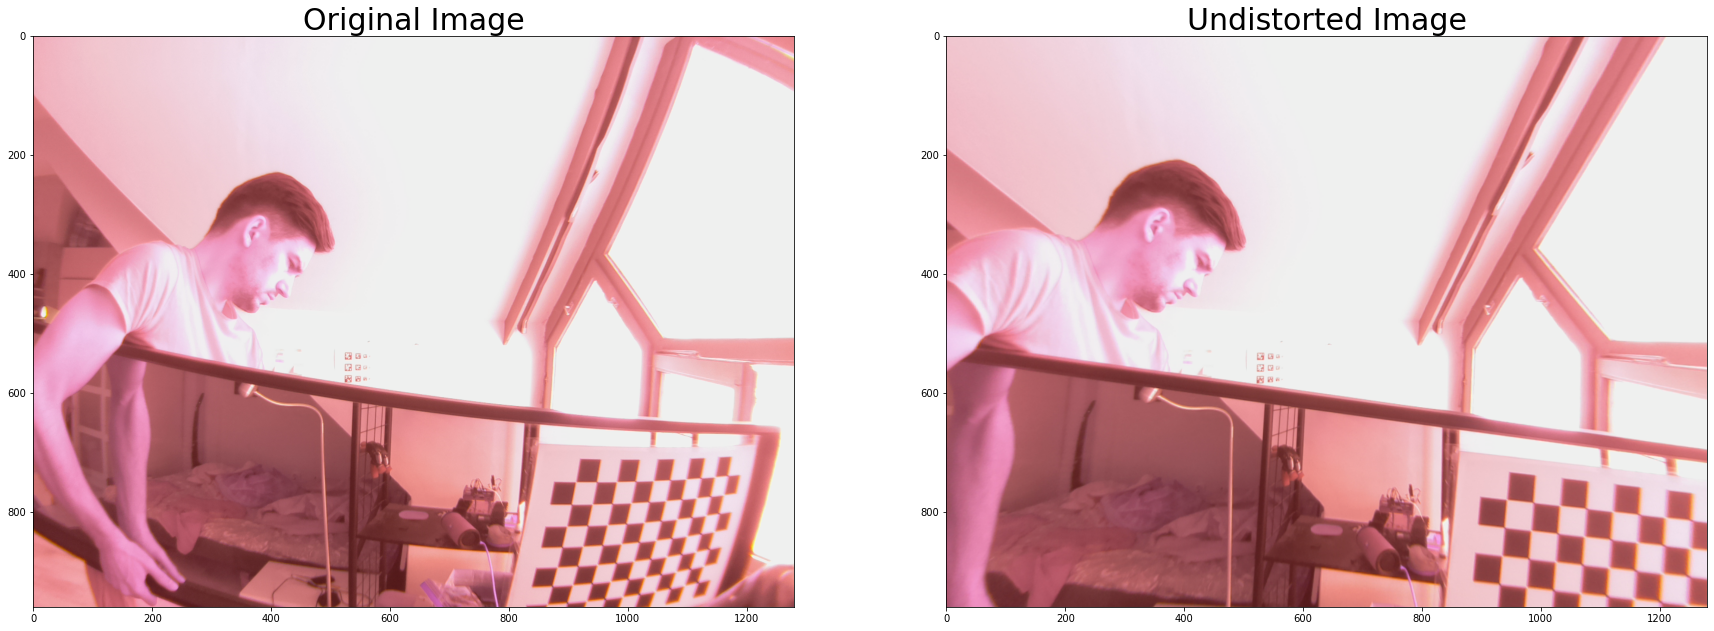

In [108]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread(random.choice(image_paths))
img_size = (img.shape[1], img.shape[0])
print(img.shape[:2])
# Do camera calibration given object points and image points


DIM=img_size
h,w = img.shape[:2]
map1, map2 = cv2.fisheye.initUndistortRectifyMap(mtx, dist, np.eye(3), mtx, DIM, cv2.CV_16SC2)
undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)


ret, corners = cv2.findChessboardCorners(img, (CHECKERBOARD[0],CHECKERBOARD[1]), None)

# If found, add object points, image points
print("RET",ret)
if ret == True:
    subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
    cv2.drawChessboardCorners(img, (CHECKERBOARD[0],CHECKERBOARD[1]), corners, ret)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,15))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
CHECKERBOARD = (10,7)
img_size = (1280, 960)
# img_size = (640, 480)
# images_glob = '/catkin_ws/src/dataset/calib/fish640x480_1/*.jpeg'
images_glob = '/catkin_ws/src/dataset/calib/fish1280x960A3/**/*.png'

FISHEYE = 'fisheye'
PERSPECTIVE = 'perpective'
MODEL = FISHEYE
H_FLIP = False

def flip(img):
    if H_FLIP:
        img = cv2.flip(img, 0)
    return img

In [ ]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1],3), np.float32)
objp[:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1,2)

objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(images_glob)
print('found {} images'.format(len(images)))

used_image_count = 0
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = flip(cv2.imread(fname))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CHECKERBOARD[0],CHECKERBOARD[1]), None)

    # If found, add object points, image points
    if ret == True:
        used_image_count += 1
        objpoints.append(objp)
        imgpoints.append(corners)

        # # Draw and display the corners
        # cv2.drawChessboardCorners(img, (CHECKERBOARD[0],board_height), corners, ret)
        # #write_name = 'corners_found'+str(idx)+'.jpg'
        # #cv2.imwrite(write_name, img)
        # cv2.imshow('img', img)
        # cv2.waitKey(500)

print("Found corners on {} images".format(used_image_count))
cv2.destroyAllWindows()

In [ ]:
import pickle
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW
ret, K, D, rvecs, tvecs = cv2.fisheye.calibrate(objpoints, imgpoints, img_size,None,None, flags=calibration_flags)
print("RET", ret)
D_pickle = {}
D_pickle["K"] = K
D_pickle["D"] = D
pickle.dump( D_pickle, open( "camera_calibration_pickle.p", "wb" ) )

print(K, '\n', D)
print("Camera.fx:", K[0][0])
print("Camera.fy:", K[1][1])
print("Camera.cx:", K[0][2])
print("Camera.cy:", K[1][2])

print('\n')
print('Camera.k1:', D[0][0])
print('Camera.k2:', D[1][0])
print('Camera.k3:', D[2][0])
print('Camera.k4:', D[3][0])


In [ ]:


Camera.fx: 736.799380041753
Camera.fy: 738.1296110449435
Camera.cx: 623.0269851507727
Camera.cy: 479.41796594759063


Camera.k1: -0.011885462079235002
Camera.k2: -0.04402188574632658
Camera.k3: 0.06925286809391396
Camera.k4: -0.0457320089421333

In [ ]:
import cv2
# assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import os
import glob
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob(images_glob)
used_image_count = 0
for fname in images:
    img = flip(cv2.imread(fname))
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD)
    # print("{} - found {} corners".format(fname, len(corners) if ret == True else 0))
    # If found, add object points, image points (after refining them)
    if ret == True:
        used_image_count += 1
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
print("Found corners on {} images".format(used_image_count))


In [ ]:

N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
# rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
# tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
ret, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        # rvecs,
        # tvecs,
        flags=calibration_flags,
        # (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )
print("RET", ret)
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print(K, '\n', D)
print("Camera.fx:", K[0][0])
print("Camera.fy:", K[1][1])
print("Camera.cx:", K[0][2])
print("Camera.cy:", K[1][2])

print('\n')
print('Camera.k1:', D[0][0])
print('Camera.k2:', D[1][0])
print('Camera.k3:', D[2][0])
print('Camera.k4:', D[3][0])


In [ ]:

Camera.fx: 736.5015466535494
Camera.fy: 737.7523633241663
Camera.cx: 622.7962516403339
Camera.cy: 479.59388922989496


Camera.k1: -0.010955659973999754
Camera.k2: -0.047002618776998864
Camera.k3: 0.059114596046676536
Camera.k4: -0.032725046003063904


Camera.fx: 736.799380041753
Camera.fy: 738.1296110449435
Camera.cx: 623.0269851507727
Camera.cy: 479.41796594759063


Camera.k1: -0.011885462079235002
Camera.k2: -0.04402188574632658
Camera.k3: 0.06925286809391396
Camera.k4: -0.0457320089421333

In [ ]:
print(K)
print("fx:", K[0][0])
print("fy:", K[1][1])
print("cx:", K[0][2])
print("cy:", K[1][2])

print('\n\n', D)
print('k1:', D[0][0])
print('k2:', D[1][0])
print('k3:', D[2][0])
print('k4:', D[3][0])